
# DATA 101 — Module 10, Session 1 Demo  
**Classification basics: Logistic Regression and Decision Trees**

This notebook mirrors the lecture:
- Binary classification setup
- Train/test split
- Logistic regression and decision tree
- Confusion matrix, precision, recall, F1, accuracy
- ROC curve and AUC
- Threshold effects
- Brief model comparison


In [1]:
# Core
import numpy as np
import pandas as pd

# Modeling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree

# Metrics
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_curve,
    roc_auc_score
)

# Data
from sklearn.datasets import load_breast_cancer

# Plotting
import matplotlib.pyplot as plt

# Reproducibility
RANDOM_STATE = 1
np.random.seed(RANDOM_STATE)


## 1) Data
Use the Breast Cancer Wisconsin dataset. Target: malignant (1) vs benign (0).


In [2]:
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name="target")  # 0 = malignant? In this dataset: 0 = malignant, 1 = benign
# To match lecture convention "class 1 = positive", set positive class = malignant.
# Flip target so that 1 = malignant, 0 = benign.
y = 1 - y

X.shape, y.value_counts().to_dict()

((569, 30), {0: 357, 1: 212})


## 2) Train/Test Split
70% train, 30% test.


In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=RANDOM_STATE, stratify=y
)

X_train.shape, X_test.shape

((398, 30), (171, 30))


## 3) Logistic Regression
Fit, predict, and evaluate.


In [4]:
logit = LogisticRegression(max_iter=5000, solver="lbfgs")
logit.fit(X_train, y_train)

y_pred_lr = logit.predict(X_test)
y_proba_lr = logit.predict_proba(X_test)[:, 1]

acc_lr  = accuracy_score(y_test, y_pred_lr)
prec_lr = precision_score(y_test, y_pred_lr, zero_division=0)
rec_lr  = recall_score(y_test, y_pred_lr, zero_division=0)
f1_lr   = f1_score(y_test, y_pred_lr, zero_division=0)
auc_lr  = roc_auc_score(y_test, y_proba_lr)

report_lr = classification_report(y_test, y_pred_lr, target_names=["benign(0)","malignant(1)"])

cm_lr = pd.DataFrame(confusion_matrix(y_test, y_pred_lr),
                     index=["Actual 0","Actual 1"],
                     columns=["Pred 0","Pred 1"])

print("Logistic Regression — test metrics")
print(pd.Series({
    "accuracy": acc_lr,
    "precision": prec_lr,
    "recall": rec_lr,
    "f1": f1_lr,
    "auc": auc_lr
}).round(4))

Logistic Regression — test metrics
accuracy     0.9357
precision    0.9649
recall       0.8594
f1           0.9091
auc          0.9879
dtype: float64


In [5]:
print("\nConfusion matrix:")
display(cm_lr)


Confusion matrix:


,Pred 0,Pred 1
Actual 0,105,2
Actual 1,9,55


In [6]:
print("\nClassification report:")
print(report_lr)


Classification report:
              precision    recall  f1-score   support

   benign(0)       0.92      0.98      0.95       107
malignant(1)       0.96      0.86      0.91        64

    accuracy                           0.94       171
   macro avg       0.94      0.92      0.93       171
weighted avg       0.94      0.94      0.93       171




### ROC Curve and AUC — Logistic Regression


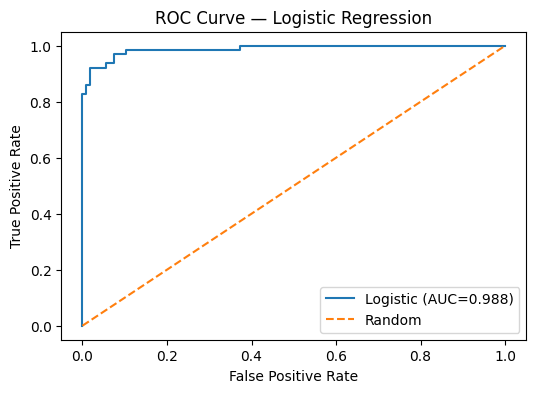

In [7]:
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)
plt.figure(figsize=(6,4))
plt.plot(fpr_lr, tpr_lr, label=f"Logistic (AUC={auc_lr:.3f})")
plt.plot([0,1],[0,1], linestyle="--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Logistic Regression")
plt.legend()
plt.show()


## 4) Threshold Effects
By default, `predict` uses threshold 0.5. Try 0.30 and 0.70 to see precision/recall trade-offs.


In [8]:
def evaluate_at_threshold(y_true, y_proba, thr):
    y_pred = (y_proba >= thr).astype(int)
    return {
        "threshold": thr,
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "f1": f1_score(y_true, y_pred, zero_division=0)
    }

rows = [evaluate_at_threshold(y_test, y_proba_lr, t) for t in [0.30, 0.50, 0.70]]
pd.DataFrame(rows).round(4)

,threshold,accuracy,precision,recall,f1
0,0.3,0.9532,0.9667,0.9062,0.9355
1,0.5,0.9357,0.9649,0.8594,0.9091
2,0.7,0.9298,0.9815,0.8281,0.8983



## 5) Decision Tree
Depth-limited to control overfitting.


In [9]:
tree = DecisionTreeClassifier(max_depth=3, random_state=RANDOM_STATE)
tree.fit(X_train, y_train)

y_pred_dt = tree.predict(X_test)
y_proba_dt = tree.predict_proba(X_test)[:, 1]

acc_dt  = accuracy_score(y_test, y_pred_dt)
prec_dt = precision_score(y_test, y_pred_dt, zero_division=0)
rec_dt  = recall_score(y_test, y_pred_dt, zero_division=0)
f1_dt   = f1_score(y_test, y_pred_dt, zero_division=0)
auc_dt  = roc_auc_score(y_test, y_proba_dt)

report_dt = classification_report(y_test, y_pred_dt, target_names=["benign(0)","malignant(1)"])

cm_dt = pd.DataFrame(confusion_matrix(y_test, y_pred_dt),
                     index=["Actual 0","Actual 1"],
                     columns=["Pred 0","Pred 1"])

print("Decision Tree — test metrics")
print(pd.Series({
    "accuracy": acc_dt,
    "precision": prec_dt,
    "recall": rec_dt,
    "f1": f1_dt,
    "auc": auc_dt
}).round(4))

Decision Tree — test metrics
accuracy     0.9181
precision    0.9464
recall       0.8281
f1           0.8833
auc          0.9136
dtype: float64


In [10]:
print("\nConfusion matrix:")
display(cm_dt)


Confusion matrix:


,Pred 0,Pred 1
Actual 0,104,3
Actual 1,11,53


In [11]:
print("\nClassification report:")
print(report_dt)


Classification report:
              precision    recall  f1-score   support

   benign(0)       0.90      0.97      0.94       107
malignant(1)       0.95      0.83      0.88        64

    accuracy                           0.92       171
   macro avg       0.93      0.90      0.91       171
weighted avg       0.92      0.92      0.92       171




### Visualize the Tree


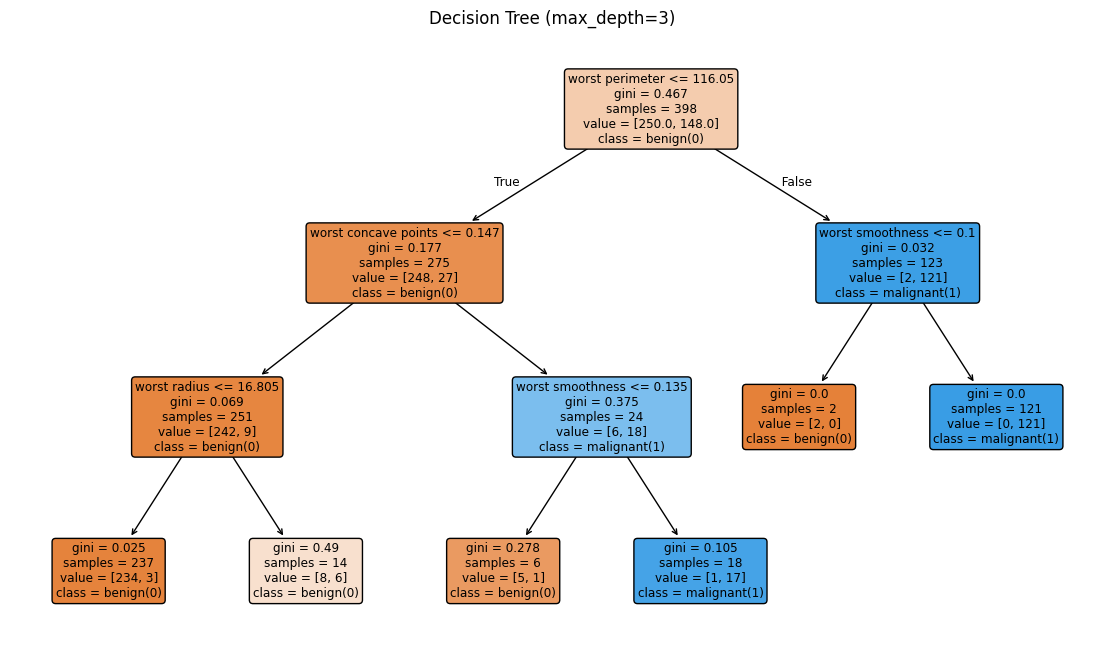

In [12]:
plt.figure(figsize=(14,8))
plot_tree(tree, filled=True, feature_names=X.columns, class_names=["benign(0)","malignant(1)"], rounded=True)
plt.title("Decision Tree (max_depth=3)")
plt.show()


## 6) Quick Comparison


In [13]:
comparison = pd.DataFrame([
    {"model":"Logistic Regression","accuracy":acc_lr,"precision":prec_lr,"recall":rec_lr,"f1":f1_lr,"auc":auc_lr},
    {"model":"Decision Tree (depth=3)","accuracy":acc_dt,"precision":prec_dt,"recall":rec_dt,"f1":f1_dt,"auc":auc_dt},
]).round(4)

comparison

,model,accuracy,precision,recall,f1,auc
0,Logistic Regression,0.9357,0.9649,0.8594,0.9091,0.9879
1,Decision Tree (depth=3),0.9181,0.9464,0.8281,0.8833,0.9136


### ROC Curves — Both Models

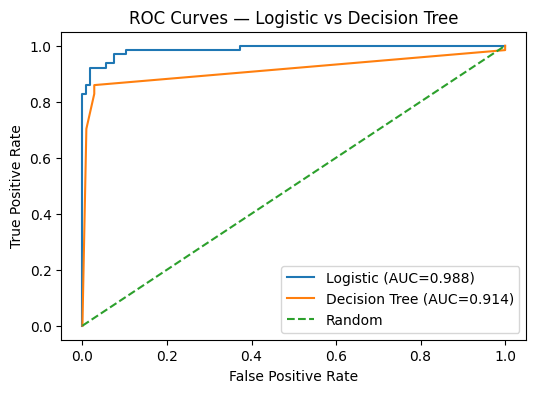

In [14]:
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_proba_dt)

plt.figure(figsize=(6,4))
plt.plot(fpr_lr, tpr_lr, label=f"Logistic (AUC={auc_lr:.3f})")
plt.plot(fpr_dt, tpr_dt, label=f"Decision Tree (AUC={auc_dt:.3f})")
plt.plot([0,1],[0,1], linestyle="--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves — Logistic vs Decision Tree")
plt.legend()
plt.show()


## 7) Takeaways
- Classification predicts labels; probabilities help set thresholds.
- Accuracy can mislead with imbalance. Precision and recall reveal trade-offs.
- AUC summarizes ranking quality across thresholds.
- Logistic regression is a strong baseline and interpretable via coefficients.
- Trees are intuitive but can overfit without constraints.
